# 라이브러리 및 패키지

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from PIL import Image

# Tensorflow Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers, models, Sequential
from keras.layers import LSTM, Conv2D, BatchNormalization, MaxPool2D, Flatten, Dense, Activation, Dropout, Input, Embedding, Masking
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers, metrics
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# System libraries
import os
import pathlib
from tqdm import tqdm
from glob import glob

# Metrics
from sklearn.metrics import classification_report, confusion_matrix
import itertools

tf.__version__, keras.__version__

('2.11.0', '2.11.0')

# 데이터 로드

In [ ]:
# 데이터 프레임 만들기

data = pd.DataFrame(columns = ['Img', 'isFire'])


# 이미지 이진 분류 파일 설정( 화재, 화재 X)
import glob

fires = glob.glob('/content/drive/MyDrive/TEST/테스트_데이터/fire/*')
non_fires = glob.glob('/content/drive/MyDrive/TEST/테스트_데이터/non_fire/*')

# 화재가 아닌 데이터
for non_fire in non_fires:
  data = data.append(pd.DataFrame([[non_fire, 0]], columns = ['Img', 'isFire']))

# 화재인 데이터  
for fire in fires:
  data = data.append(pd.DataFrame([[fire, 1]], columns = ['Img', 'isFire']))

# 인덱스 초기화
data = data.reset_index(drop = True)
data

,Img,isFire
0,/content/drive/MyDrive/동엽/data/fire_datase...,0
1,/content/drive/MyDrive/동엽/data/fire_datase...,0
2,/content/drive/MyDrive/동엽/data/fire_datase...,0
3,/content/drive/MyDrive/동엽/data/fire_datase...,0
4,/content/drive/MyDrive/동엽/data/fire_datase...,0
...,...,...
1745,/content/drive/MyDrive/동엽/data/Fire-Detect...,1
1746,/content/drive/MyDrive/동엽/data/Fire-Detect...,1
1747,/content/drive/MyDrive/동엽/data/Fire-Detect...,1
1748,/content/drive/MyDrive/동엽/data/Fire-Detect...,1


# EDA

[Text(0, 0, '785'), Text(0, 0, '965')]

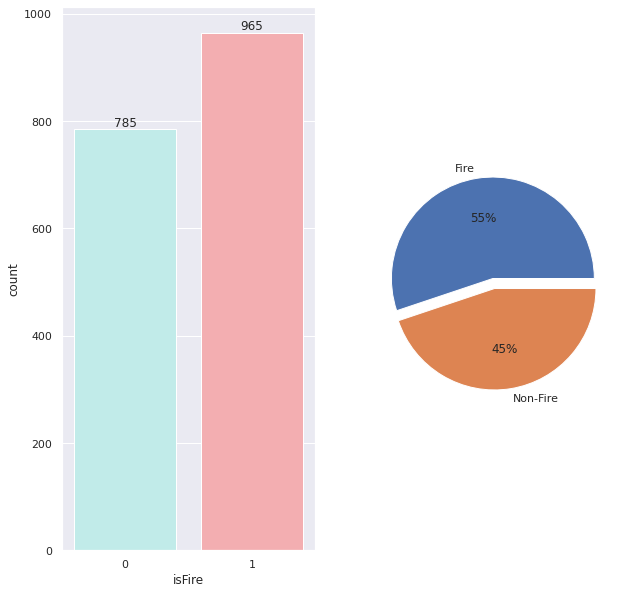

In [ ]:
sns.set_theme(style="darkgrid")
plt.rcParams['figure.figsize'] = 10,10
plt.subplot(1, 2, 2)
plt.pie(data.isFire.value_counts(), labels = ['Fire', 'Non-Fire'], autopct='%.0f%%', explode = [0, 0.1])
plt.subplot(1, 2, 1)
ax = sns.countplot(x = "isFire", data = data, palette = ['#baf2ef', '#ffa2a7'])
ax.bar_label(ax.containers[0])

# 화재(0)에 대한 비율이 화재가 아닌 비율(1)에 비해 적다

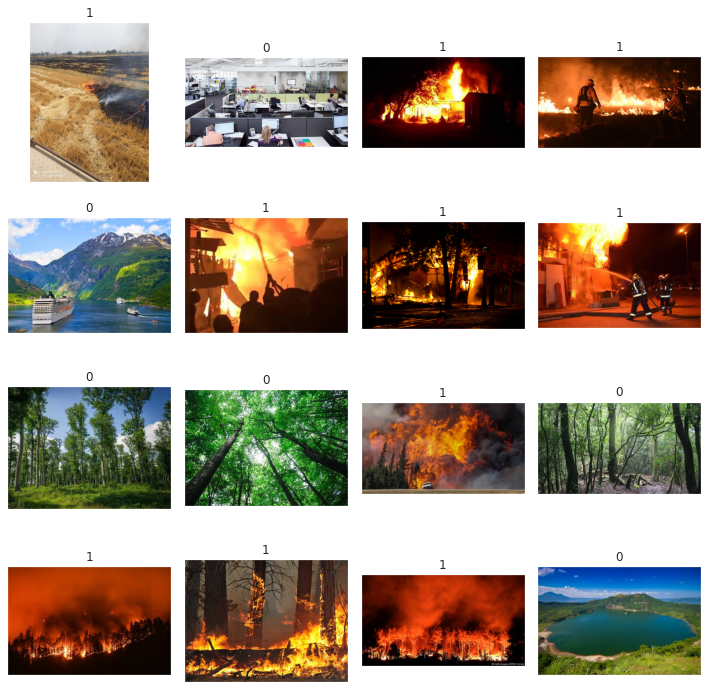

In [ ]:
import matplotlib.image as mpimg
# Display 16 picture of the dataset with their labels

random_index = np.random.randint(0, len(data), 16)

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10), subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    sample = Image.open(data.Img[random_index[i]])
    ax.imshow(sample)
    ax.set_title(data.isFire[random_index[i]])
plt.tight_layout()
plt.show()

In [ ]:
def shaper(row):
    shape = Image.open(row['Img']).size
    row['width'] = shape[0]
    row['height'] = shape[1]
    return row
sized = data.apply(shaper,axis=1)
sized.head(5)

,Img,isFire,width,height
0,/content/drive/MyDrive/동엽/data/fire_datase...,0,1024,685
1,/content/drive/MyDrive/동엽/data/fire_datase...,0,960,638
2,/content/drive/MyDrive/동엽/data/fire_datase...,0,700,467
3,/content/drive/MyDrive/동엽/data/fire_datase...,0,700,500
4,/content/drive/MyDrive/동엽/data/fire_datase...,0,800,600


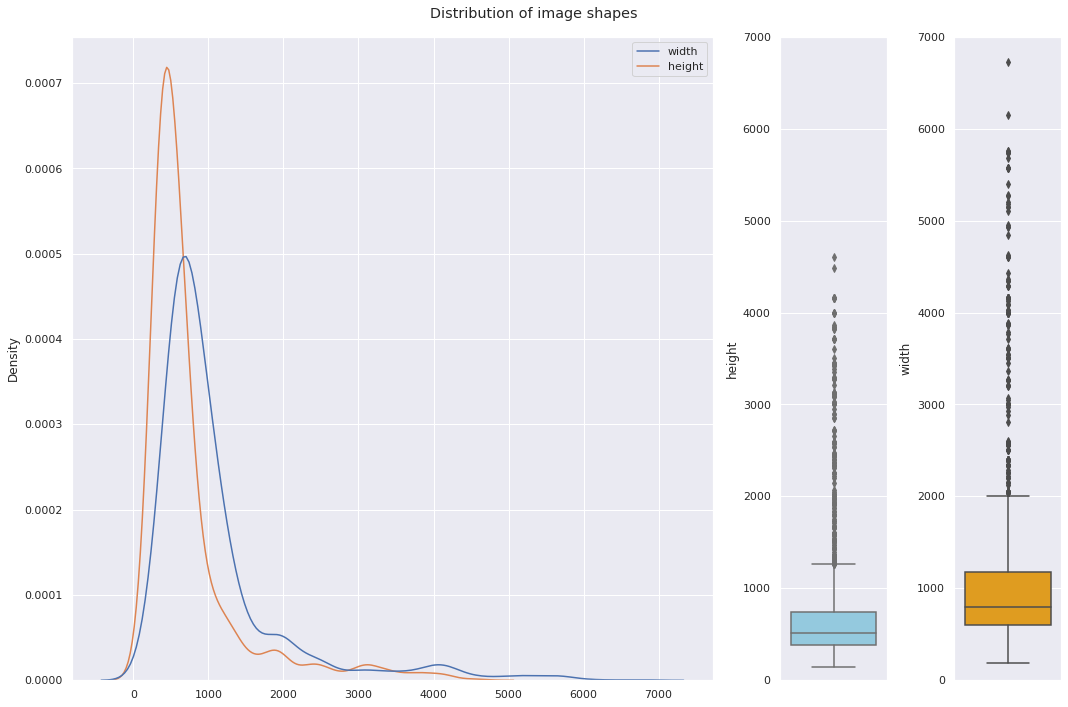

In [ ]:
sns.set_style('darkgrid')
fig,(ax1,ax2,ax3) = plt.subplots(1,3,gridspec_kw={'width_ratios': [3,0.5,0.5]},figsize=(15,10))

sns.kdeplot(data=sized.drop(columns=['Img','isFire']),ax=ax1,legend=True)
sns.boxplot(data=sized,y='height',ax=ax2,color='skyblue')
sns.boxplot(data=sized,y='width',ax=ax3,color='orange')

plt.suptitle('Distribution of image shapes')
ax3.set_ylim(0,7000)
ax2.set_ylim(0,7000)
plt.tight_layout()

# 이미지마다 크기,높이가 다르므로 학습 전, 이미지 사이즈 재조정 필요하게 보인다

# 전처리

In [ ]:
import cv2

# 크기 조절, 스케일링, 이미지 -> 배열 전환
def GiveImages(data):
    image_array = [] 
    class_name = []
    non_image = []
    IMG_SIZE = 256 # 표준 이미지 사이즈 ( 256 * 256 ) 설정
    
    for i in tqdm(range(data.shape[0])):
        image = cv2.imread(data.Img[i], cv2.COLOR_BGR2RGB) # BGR -> RGB 형태 변환
        try:
          image = cv2.resize(image, (IMG_SIZE, IMG_SIZE), interpolation = cv2.INTER_CUBIC) # 정사각형 이미지로 설정
        except:
          non_image = i # 이미지 상 오류 발생하는 경우 있음
          continue
        image = np.array(image) # 이미지를 배열 전환
        image = image.astype('float32') # 데이터 타입 변환
        image /= 255 # 사이즈 조절
        
        image_array.append(image)
        class_name.append(data['isFire'][i])

    return np.array(image_array), np.array(class_name), non_image

X, y, non_img = GiveImages(data)
#Show the shape of X and Y
X.shape, y.shape, non_img

100%|██████████| 1750/1750 [02:20<00:00, 12.44it/s]


((1749, 256, 256, 3), (1749,), 131)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1399, 256, 256, 3), (350, 256, 256, 3), (1399,), (350,))

In [ ]:
print('NON-FIRE IMAGES ON TRAINING DATA: ',y_train[y_train==0].shape[0])
print('FIRE IMAGES ON TRAINING DATA: ',y_train[y_train==1].shape[0])

NON-FIRE IMAGES ON TRAINING DATA:  632
FIRE IMAGES ON TRAINING DATA:  767


# 인공신경망 설계 ( CNN )

In [ ]:
# 전체 시퀀스 생성
# 다층 퍼셉트론 : https://buomsoo-kim.github.io/keras/2018/04/24/Easy-deep-learning-with-Keras-5.md/
'''
    < Conv2D 주요 파라미터 체크 >
      filters, # 출력 채널 수 지정, 합성곱층을 통과 후 데이터 출력 채널 수 자정
      kernel_size, # k : w를 파라미터로 가지는 커널(크기가 존재, 정방형 행렬), 설정(5,5)
      strides=(1, 1), # s : 커널의 이동량 (왼->오, 위->아래), 설정 1칸씩 이동
      padding='valid', # p : 커널이 이미지 원본사이를 s양 만큼 슬라이딩 할때 경계선에 도착 못하는 경우 이를 보정하는( 경계선에 도착 ) 방법
                             설정 : same -> 원본과 동일한 feature map이 출력된다. 단, s가 1이여야 한다
      activation=None, # feature map -> activation map으로 처리 할 때 지정, 활성화 함수 사용 ( 주로 relu 사용 )
      use_bias=True, # b : 편향값 사용 ?
      kernel_initializer='glorot_uniform', # 가중치 초기값에 사용되는 함수
      bias_initializer='zeros',  # 편향의 초기값 지정 -> 0
   
    < MaxPool2D  파라미터 체크 >
  - 최대값 연산 -> 특징 강화, W, b는 없다
     pool_size  # 커널의 크기 설정
     strides # 커널의 이동량, None이면 pool_size와 동일
     padding # 원본과 동일한 크기로 진행, 단 poolsize, strides에 따라 달라질 수 있음
'''
model = Sequential()

# # 전처리 과정 
# model.add(layers.RandomContrast(0.1))
# model.add(layers.RandomRotation(0.1))
# model.add(layers.RandomZoom(0.2))

# # 합성곱층 2f
model.add(Conv2D(32, kernel_size =(3,3), strides=(1, 1), padding='same', activation='relu', input_shape = (256,256,3) ))
# 배치 정규화
model.add(BatchNormalization())
# 풀링층 2f
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Conv2D(64, kernel_size =(3,3), activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Conv2D(128, kernel_size =(3,3),activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (2,2)))
# 전결합층 => 4D -> 2D
model.add(Flatten())
# 출력층
model.add(Dense(64, activation='relu'))
# 과적합 방지층, 설정 값 : 0.1 -> 10% 비율로 학습 방해 , 1 / 1-(0.1) 비율 적용
model.add(layers.Dropout(0.1))
model.add(Dense(32, activation='relu'))
model.add(layers.Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))
model.add(layers.Dropout(0.1))
# 모델 요약
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 126, 126, 64)      18496     
                                                                 
 batch_normalization_1 (Batc  (None, 126, 126, 64)     256       
 hNormalization)                                                 
                                                        

# 컴파일

In [ ]:
# 학습 전 평가지표, 평가도구, 최적화도구 지정
model.compile(
    optimizer = optimizers.Adam(learning_rate = 0.0001), # 최적화 도구 
    loss = 'binary_crossentropy', # 손실함수 : 값이 0에 가까울 수록 좋다 
    metrics = ['accuracy']
)

# 학습

In [ ]:
# 학습 변수 설정
EPOCH = 30 # 설정 : 학습
BATCH_SIZE = 128 # 설정 : 1회 학습 시 128개 데이터 사용
IS_GPU = True

In [ ]:
my_callbacks = [
  # 조기학습 종료가 되고, patiemce 회수만큼 더 학습을 수행하는데 변동이 없다면 종료
  EarlyStopping(
    monitor = "val_loss",
    patience = 10,
    restore_best_weights = True
  ),
  # 모델 저장, 옵션따라 조건이 달라짐. 기본값 기준 세대별 저장
  ModelCheckpoint(
    filepath='/content/drive/MyDrive/동엽/model_save/model_{epoch:02d}-{val_loss:.2f}.h5',
    save_weights_only=True,
    monitor="val_accuracy",
    save_best_only=True
  ),
  # 텐서보드 로드용 데이터 저장
  TensorBoard(log_dir='./logs'),

  # Learning Rate를 조절해 모델의 개선을 유도 :  https://deep-deep-deep.tistory.com/56
  ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 5),
]

In [ ]:
def training():
  '''
    x=None, # 훈련데이터 중 피처 
    y=None, # 훈련데이터 중 정답
    batch_size=None, # 1회 학습 시 사용되는 데이터량
    epochs=1, # 몇세대 학습 할 것인가?
    verbose='auto', # 로그 출력
    callbacks=None, # 학습 중 특정 이벤트가 발생 시 자동으로 콜백함수가 호출되서 업무 수행 -> 조기학습 종료
    validation_split=0.0, # 훈련 데이터에서 특정 비율을 검증용으로 사용
    validation_data=None # 검증용으로 데이터를 별도로 지정한다
  '''
  return model.fit(
      X_train, 
      y_train,
      batch_size = BATCH_SIZE,
      epochs = EPOCH,
      validation_data = (X_test, y_test), # 편의상 검증용 제너레이터가 없어서 테스트용 사용 -> 과적합 방지
      callbacks = my_callbacks
  )
  pass

## CPU 학습

In [ ]:
%%time
if not IS_GPU:
  hist = training()
  pass

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.87 µs


## GPU 학습

In [ ]:
%%time
if IS_GPU:
  with tf.device('/device:GPU:0'):
    hist = training()
  pass

Epoch 1/30
11/11 [==============================] - 25s 826ms/step - loss: 1.7726 - accuracy: 0.7155 - val_loss: 0.6922 - val_accuracy: 0.4629 - lr: 1.0000e-04
Epoch 2/30
11/11 [==============================] - 4s 364ms/step - loss: 1.4315 - accuracy: 0.8041 - val_loss: 0.7239 - val_accuracy: 0.4771 - lr: 1.0000e-04
Epoch 3/30
11/11 [==============================] - 4s 379ms/step - loss: 1.2597 - accuracy: 0.8506 - val_loss: 0.7185 - val_accuracy: 0.4486 - lr: 1.0000e-04
Epoch 4/30
11/11 [==============================] - 5s 419ms/step - loss: 1.2480 - accuracy: 0.8542 - val_loss: 0.5926 - val_accuracy: 0.7543 - lr: 1.0000e-04
Epoch 5/30
11/11 [==============================] - 4s 382ms/step - loss: 1.2957 - accuracy: 0.8492 - val_loss: 0.5760 - val_accuracy: 0.6686 - lr: 1.0000e-04
Epoch 6/30
11/11 [==============================] - 4s 354ms/step - loss: 1.3515 - accuracy: 0.8628 - val_loss: 0.6160 - val_accuracy: 0.6229 - lr: 1.0000e-04
Epoch 7/30
11/11 [===========================

# 모델 평가

In [ ]:
# 모델 정보 시각화
keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [ ]:
model.evaluate(X_test, y_test)

11/11 [==============================] - 1s 57ms/step - loss: 0.5374 - accuracy: 0.7486


[0.5373629927635193, 0.7485714554786682]

In [ ]:
hist.history

{'loss': [1.772603154182434,
  1.4315130710601807,
  1.2596676349639893,
  1.247991919517517,
  1.2957028150558472,
  1.3515313863754272,
  1.2670809030532837,
  1.153814435005188,
  1.3915469646453857,
  1.1686992645263672,
  1.3656866550445557,
  1.3176047801971436,
  1.1169270277023315,
  1.0503897666931152,
  1.2168861627578735,
  1.0462321043014526,
  1.1189994812011719,
  0.9291348457336426,
  1.0051504373550415,
  1.0663549900054932],
 'accuracy': [0.7155110836029053,
  0.8041458129882812,
  0.8506075739860535,
  0.8541815876960754,
  0.8491779565811157,
  0.8627591133117676,
  0.8663330674171448,
  0.8791994452476501,
  0.8527519702911377,
  0.8606147170066833,
  0.8677626848220825,
  0.8756254315376282,
  0.8949249386787415,
  0.8977841138839722,
  0.873481035232544,
  0.9006432890892029,
  0.9027876853942871,
  0.9099356532096863,
  0.907791256904602,
  0.9106504917144775],
 'val_loss': [0.6921559572219849,
  0.7239428758621216,
  0.7184848189353943,
  0.5926463007926941,
  0

In [ ]:
import plotly.express as px
history = hist.history
px.line(history,title = "Metrics Plot")

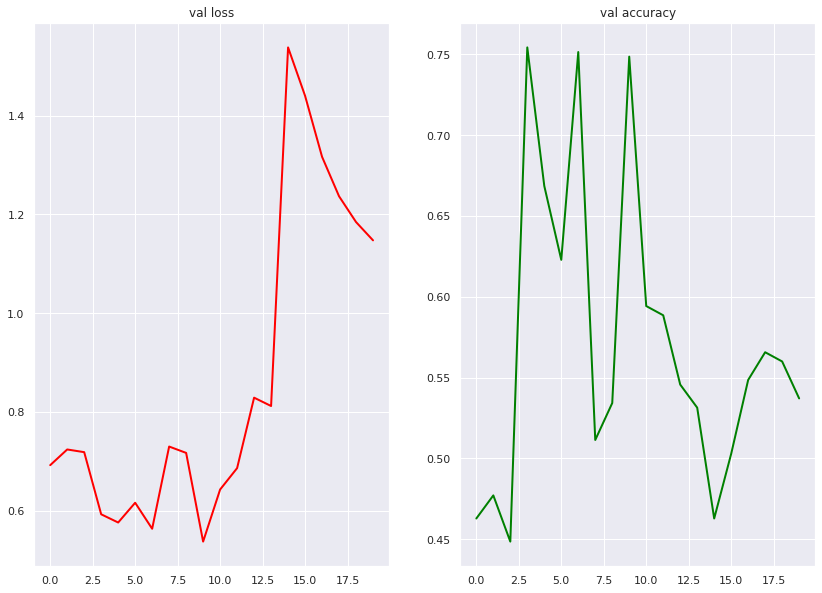

In [ ]:
fig, axes = plt.subplots(1,2,figsize=(14,10))
axes[0].set_title('val loss');
axes[1].set_title('val accuracy')

axes[0].plot(history['val_loss'], color = 'red', lw=2);
axes[1].plot(history['val_accuracy'], color = 'green', lw=2);

11/11 [==============================] - 0s 29ms/step
              precision    recall  f1-score   support

           0       0.73      0.68      0.70       152
           1       0.76      0.80      0.78       198

    accuracy                           0.75       350
   macro avg       0.74      0.74      0.74       350
weighted avg       0.75      0.75      0.75       350



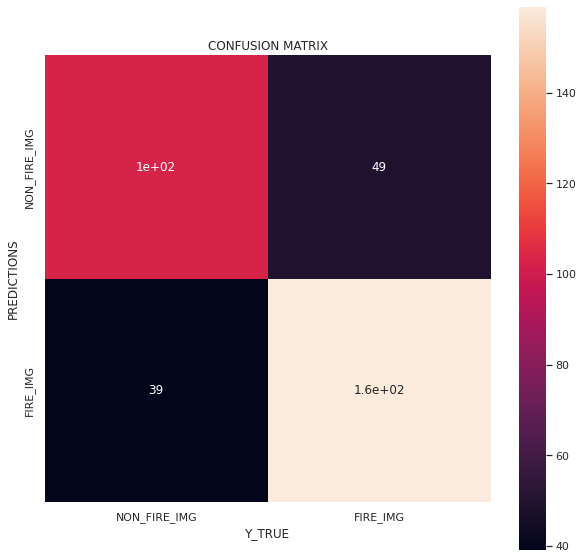

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report 

y_pred = (model.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test, y_pred))

confusion_mat = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10,10))
sns.heatmap(confusion_mat, 
            square=True, 
            annot=True,
            yticklabels=['NON_FIRE_IMG', 'FIRE_IMG'],
            xticklabels=['NON_FIRE_IMG', 'FIRE_IMG']);
plt.title('CONFUSION MATRIX');
plt.xlabel('Y_TRUE');
plt.ylabel("PREDICTIONS");